# Test notebook for Acceptance Test Campaign related to LSST Science Pipelines Release 20.0

This test will be executed on the LSST Science Platform Notebook Aspect, initialized with Science Pipelines release `r20-0-0`.

### Test case LVV-T36: Verify implementation of Difference Exposures
Verify successful creation of a
1. PSF-matched template image for a given Processed Visit Image
2. Difference Exposure from each Processed Visit Image

In [1]:
# Confirm that the version of the Science Pipelines is v20_0_0:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin-r20-0-0
lsst_distrib          20.0.0     	current v20_0_0 setup


In [2]:
import lsst.daf.persistence as dafPersist
# import lsst.daf.butler as dafButler ### Gen 3 Butler
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)
import lsst.daf.persistence as dafPersist ### Gen 2 Butler (dafPersist.Butler)

In [3]:
zscale = ZScaleInterval()

# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (12, 8)})
plt.rcParams.update({'font.size' : 12})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 3})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

### Load and examine some HSC data from PDR2

In [86]:
# Meredith pointed me to where she has run HSC data through diff imaging:
diffim_repo = '/project/mrawls/cosmos/rerun/ap_pipe-g-202007'

In [87]:
butler = dafPersist.Butler(diffim_repo)

In [92]:
# Pick a visit/ccd at random:
dataId = {'visit': 106078, 'ccd': 35}

# Load the calexp image
calexp = butler.get('calexp', **dataId)

# Load the difference image
diffexp = butler.get('deepDiff_differenceExp', **dataId)

In [95]:
# Extract the images and normalize them:

im = calexp.image.array

# Create an ImageNormalize object
norm = ImageNormalize(im, interval=ZScaleInterval(),
                      stretch=LinearStretch())

diffim = diffexp.image.array

# Create an ImageNormalize object
diffnorm = ImageNormalize(diffim, interval=ZScaleInterval(),
                          stretch=LinearStretch())

### Compare the original image and the difference image

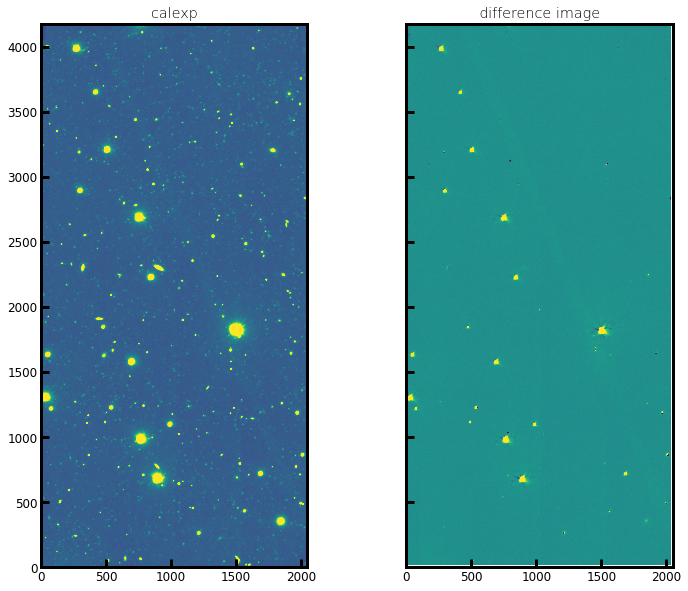

In [99]:
ncols = 2
nrows = 1
f, ax = plt.subplots(nrows=int(np.ceil(nrows)), ncols=int(ncols), sharey=True, sharex=True, figsize=(12,10))
axs = ax.flatten()

axs[0].imshow(im, norm=norm, origin='lower')
axs[0].set_title('calexp')
axs[1].imshow(diffim, norm=diffnorm, origin='lower')
axs[1].set_title('difference image')
#axs[0].imshow(im[1500:2000, 1000:1500], norm=norm, origin='lower')
#axs[1].imshow(diffim[1500:2000, 1000:1500], norm=diffnorm, origin='lower')
plt.show()

### Confirm that the difference image has flux centered on zero

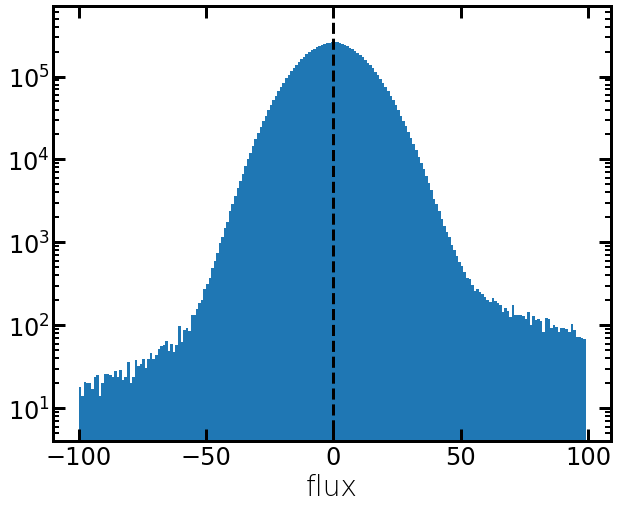

Median flux of difference image:  -0.021160766


In [128]:
params = {
   'axes.labelsize': 28,
   'font.size': 24,
   'legend.fontsize': 14,
   'xtick.major.width': 3,
   'xtick.minor.width': 2,
   'xtick.major.size': 12,
   'xtick.minor.size': 6,
   'xtick.direction': 'in',
   'xtick.top': True,
   'lines.linewidth':3,
   'axes.linewidth':3,
   'axes.labelweight':3,
   'axes.titleweight':3,
   'ytick.major.width':3,
   'ytick.minor.width':2,
   'ytick.major.size': 12,
   'ytick.minor.size': 6,
   'ytick.direction': 'in',
   'ytick.right': True,
   'figure.figsize': [10, 8]
   }

plt.rcParams.update(params)

plt.hist(np.concatenate(diffim), bins=np.arange(-100,100,1))
plt.xlabel('flux')
plt.yscale('log')
plt.ylim(4,7e5)
plt.vlines(0,0.1,1e6, linestyle='--')
plt.show()

print('Median flux of difference image: ',np.nanmedian(np.concatenate(diffim)))

### Examine the diaSource catalogs to confirm they are well-formed

In [109]:
diasrc = butler.get('deepDiff_diaSrc', **dataId)

In [111]:
diasrc.asAstropy()

<Table length=382>
        id             coord_ra      ... ip_diffim_forced_PsfFlux_flag_edge
                         rad         ...                                   
      int64            float64       ...                bool               
----------------- ------------------ ... ----------------------------------
91120458488873471 2.6124041316486366 ...                               True
91120458488873472 2.6124078550991094 ...                              False
91120458488873473  2.612439421463641 ...                              False
91120458488873474  2.612439341273957 ...                              False
91120458488873475 2.6124339985811815 ...                              False
91120458488873476 2.6124393299459943 ...                              False
91120458488873477  2.612449050389531 ...                              False
91120458488873478 2.6124503734625155 ...                              False
91120458488873479   2.61244853546165 ...                              False
              ...                ... ...                                ...
91120458488873843   2.61569735840101 ...                              False
91120458488873844 2.6156976758663553 ...                              False
91120458488873845  2.615707831998261 ...                              False
91120458488873846  2.615723086904339 ...                              False
91120458488873847 2.6157285333085523 ...                              False
91120458488873848 2.6157305362536394 ...                              False
91120458488873849 2.6157407216039172 ...                               True
91120458488873850  2.615727711613839 ...                              False
91120458488873851 2.6157395425002834 ...                               True
91120458488873852 2.6157387945248027 ...                               True

### Check that the magnitudes of the diaSources are reasonable:

In [119]:
photocalib = butler.get('deepDiff_differenceExp_photoCalib', dataId=dataId)
deepDiff_mags = photocalib.instFluxToMagnitude(diasrc, 'ip_diffim_forced_PsfFlux')

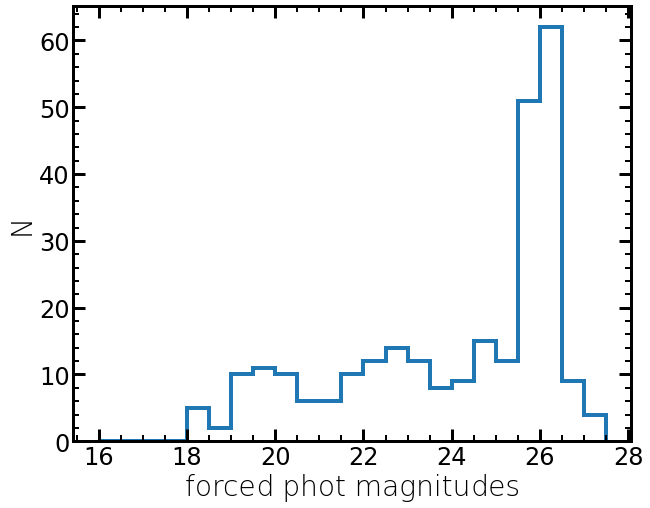

In [130]:
plt.hist(deepDiff_mags[:,0], bins=np.arange(16,28,0.5), histtype='step', linewidth=4)
plt.xlabel('forced phot magnitudes')
plt.ylabel('N')
plt.minorticks_on()
plt.show()

The magnitudes are reasonable -- between 18-27 for these sources. This is roughly what is expected for the HSC data. 

Furthermore, the table of diaSources looks well-formed and populated with reasonable values for all measured quantities.

### Check HSC images at a variety of airmasses to confirm that the difference images look good for different airmass.

In [131]:
# Make a list of visits (in HSC-G filter)
visfilelist = glob.glob('/project/mrawls/cosmos/rerun/ap_pipe-g-202007/deepDiff/*/HSC-G/DIFFEXP*035.fits')
visits = []

for i in range(len(visfilelist)):
    tmpfile = visfilelist[i]
    tmplist = np.char.split(tmpfile, sep='/') 
    tmplist1 = tmplist.take(0)[-1]
    tmplist2 = np.char.split(tmplist1, sep='-').take(0)[1]
    visits.append(tmplist2)

In [132]:
# Extract the airmass of each observation by looping over the calexp metadata
airmasses = []

for v in visits:
    dataId2 = {'visit': int(v), 'ccd': 35}
    calexp2 = butler.get('calexp', **dataId2)
    md=calexp2.getMetadata()
    airmasses.append(md['AIRMASS'])

In [144]:
vis_airmass = np.array([np.array(visits), np.array(airmasses)])

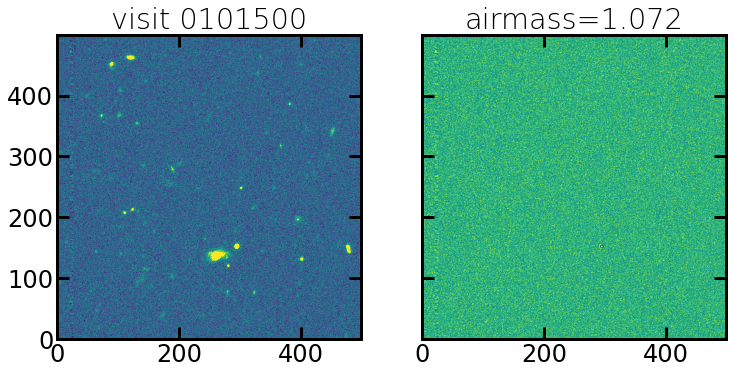

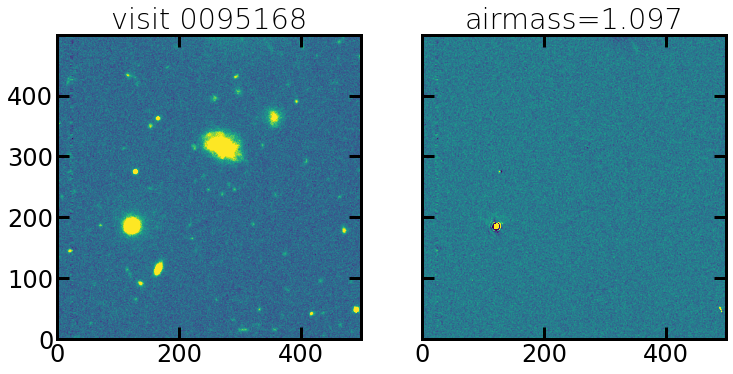

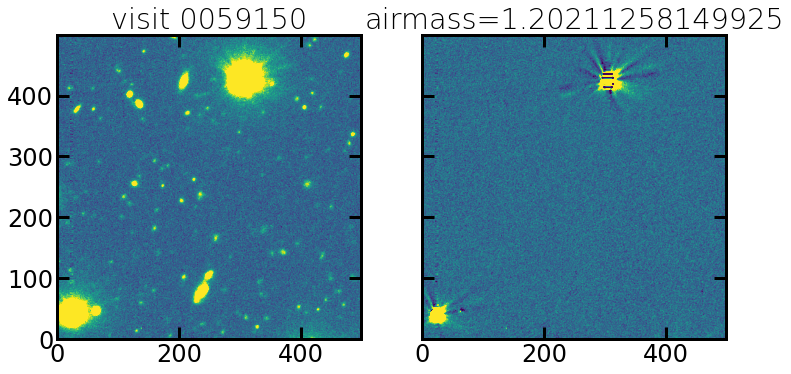

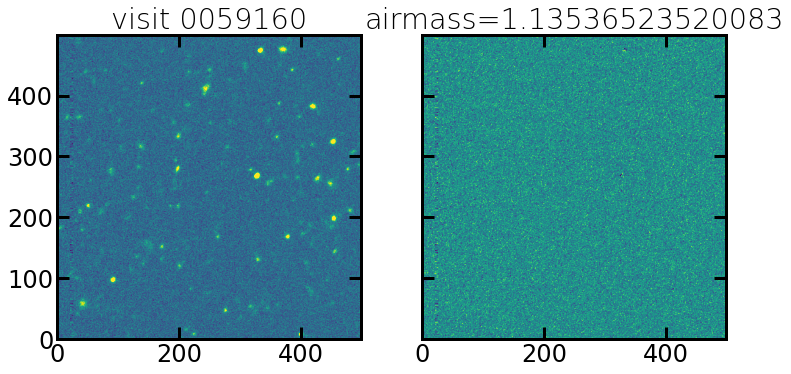

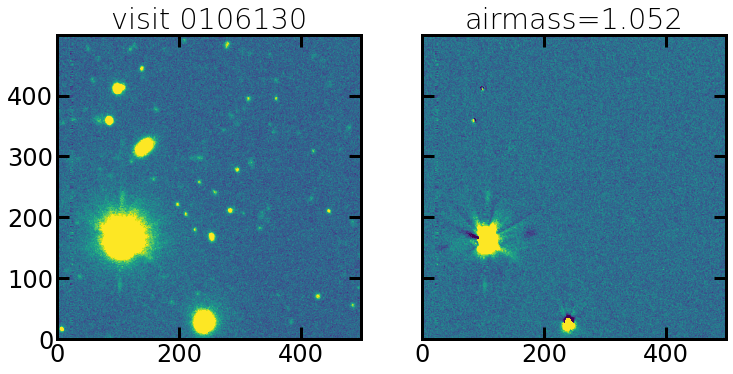

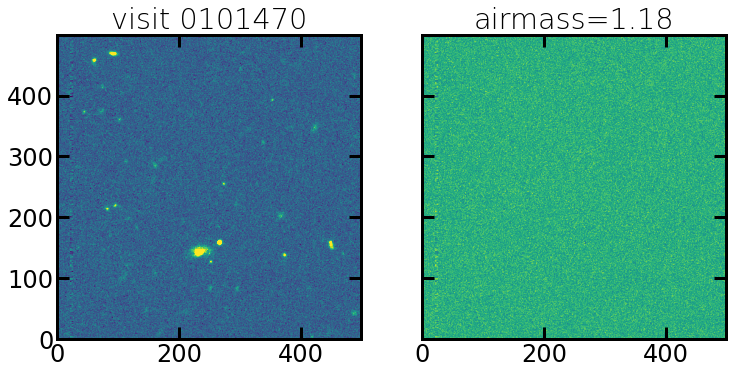

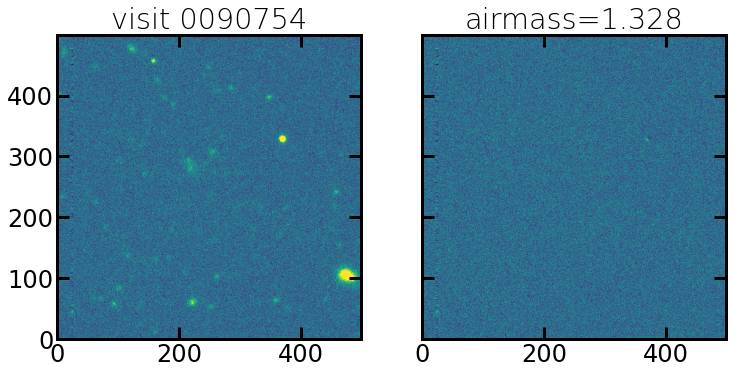

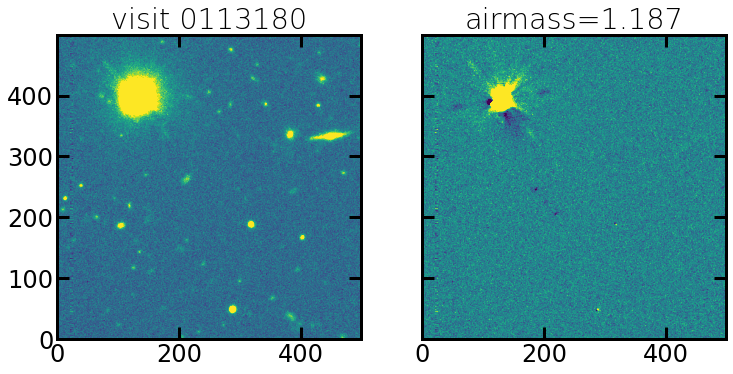

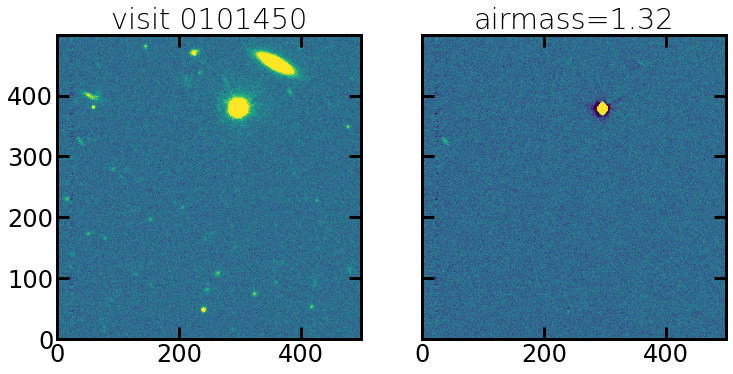

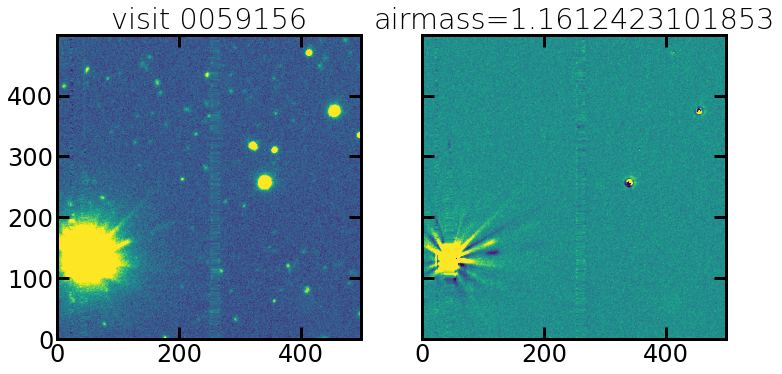

In [181]:
ncols = 2
nrows = 1
nsel = 10

# Select "nsel" at random to plot
select_inds = random.sample(range(len(visits)), k=nsel)

for ind in select_inds:
    
    # Pick a visit/ccd at random:
    dataId = {'visit': int(visits[ind]), 'ccd': 35}

    # Load the calexp image
    calexp = butler.get('calexp', **dataId)

    # Load the difference image
    diffexp = butler.get('deepDiff_differenceExp', **dataId)# Extract the images and normalize them:
    
    im = calexp.image.array

    # Create an ImageNormalize object
    norm = ImageNormalize(im, interval=ZScaleInterval(),
                          stretch=LinearStretch())

    diffim = diffexp.image.array

    # Create an ImageNormalize object
    diffnorm = ImageNormalize(diffim, interval=ZScaleInterval(),
                              stretch=LinearStretch())

    f, ax = plt.subplots(nrows=int(np.ceil(nrows)), ncols=int(ncols), sharey=True, sharex=True, figsize=(12,10))
    axs = ax.flatten()

    axs[0].imshow(im[1500:2000, 1000:1500], norm=norm, origin='lower')
    axs[1].imshow(diffim[1500:2000, 1000:1500], norm=diffnorm, origin='lower')
    axs[0].set_title('visit '+str(visits[ind]))
    axs[1].set_title('airmass='+str(airmasses[ind]))
    plt.show()

These all look like clean subtractions, no matter their airmass. 